In [ ]:
# imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

# remove warnings for my own sanity
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf.runtime_version")

Create variables for the paths where the images (data we are trying to train off of) and the labels (answer to whether the image contains a fire or not) are located as well as some standard variables used such as image size and the X and y variables

In [ ]:
# data used from https://www.kaggle.com/datasets/datascientist97/forest-fire/data

# paths (replace with wherever your data is located)
train_dir = "/Users/elipappas/.cache/kagglehub/datasets/datascientist97/forest-fire/versions/1/train"
test_dir = "/Users/elipappas/.cache/kagglehub/datasets/datascientist97/forest-fire/versions/1/test"

# training data - images and labels
train_images_dir = f"{train_dir}/images"
train_labels_dir = f"{train_dir}/labels"

# testing data - images and labels
test_images_dir = f"{test_dir}/images"
test_labels_dir = f"{test_dir}/labels"

# params
image_size = 128, 128

Function used to load the data from the folders and correctly pair the images with their labels

In [ ]:
# function to load data - takes the image and label directories 
# as inputs with an added input for image size that defaults to (128, 128)
def load_yolo_binary_dataset(images_dir, labels_dir, image_size=(128, 128)):
    # initialize X and y to empty lists
    X, y = [], []
    
    # read in label file
    for label_file in os.listdir(labels_dir):
        # if the label_file is not a .txt file skip it
        if not label_file.endswith(".txt"):
            continue
        
        # read line in each file
        with open(os.path.join(labels_dir, label_file), "r") as f:
            lines = f.readlines()
        
        # first column in the file format is the class id
        class_ids = [int(line.split()[0]) for line in lines]
        label = 1 if any(cid == 1 for cid in class_ids) else 0
        
        # match image file with any extension
        base_name = os.path.splitext(label_file)[0]
        found_image = None

        # search for image file with matching base name
        for ext in [".jpg", ".jpeg", ".png"]:
            img_path = os.path.join(images_dir, base_name + ext)
            if os.path.exists(img_path):
                found_image = img_path
                break
        
        # if there is a matching image to the label open the image and resize it
        # before adding the image to the X and the label to the y
        if found_image:
            img = Image.open(found_image).convert("RGB")
            img = img.resize(image_size)
            X.append(np.array(img))
            y.append(label)
    
    # normalize the images and convert the labels and images to a numpy array
    X = np.array(X, dtype="float32") / 255.0
    y = np.array(y)

    # return the populated arrays
    return X, y


Populate these variables using the general function above.

In [27]:
# load the training data
X_train, y_train = load_yolo_binary_dataset(train_images_dir, train_labels_dir)

# load the testing data
X_test, y_test = load_yolo_binary_dataset(test_images_dir, test_labels_dir)

Transform the images to an easier to categorize format for the model.

In [28]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

Function FireClassifier uses nn.Module to create a PyTorch model that sets up layers (conv1, conv2, and conv3) which extract features from RGB images. Each convolution is followed by a max pooling layer (pool) to reduce spatial size and after each convolution the output is flattened and passed to a fully connected layer. The final layer outputs a single value.

In [29]:
class FireClassifier(nn.Module):
    def __init__(self):
        super(FireClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()

# Instantiate the model
model = FireClassifier()

These lines below set up the training process for the PyTorch model. 

optimizer creates an Adam optimizer, updating the model's weights during training to minimize the loss. 

criterion sets the loss function to Binary Cross Entropy which is used for binary classification tasks and measures how well the model's predictions mach the true labels.

In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

FireDataset is a custom PyTorch dataset for fire images and labels, with optional transforms.

In [31]:
class FireDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray((self.images[idx] * 255).astype(np.uint8))
        img = self.transform(img) if self.transform else transforms.ToTensor()(img)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

train_dataset = FireDataset(X_train, y_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

This block trains the PyTorch fire detection model for multiple epochs, tracking loss and accuracy after each epoch.

In [32]:
# Train the model (PyTorch style)
num_epochs = 20
train_losses = []
train_accuracies = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = (outputs >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
print("training completed")

Epoch 1, Loss: 0.3455, Accuracy: 0.8566
Epoch 2, Loss: 0.2699, Accuracy: 0.8911
Epoch 3, Loss: 0.2311, Accuracy: 0.9074
Epoch 4, Loss: 0.2042, Accuracy: 0.9193
Epoch 5, Loss: 0.1873, Accuracy: 0.9263
Epoch 6, Loss: 0.1651, Accuracy: 0.9366
Epoch 7, Loss: 0.1535, Accuracy: 0.9425
Epoch 8, Loss: 0.1443, Accuracy: 0.9444
Epoch 9, Loss: 0.1351, Accuracy: 0.9488
Epoch 10, Loss: 0.1250, Accuracy: 0.9534
Epoch 11, Loss: 0.1150, Accuracy: 0.9573
Epoch 12, Loss: 0.1031, Accuracy: 0.9614
Epoch 13, Loss: 0.0981, Accuracy: 0.9638
Epoch 14, Loss: 0.0883, Accuracy: 0.9656
Epoch 15, Loss: 0.0908, Accuracy: 0.9667
Epoch 16, Loss: 0.0758, Accuracy: 0.9724
Epoch 17, Loss: 0.0778, Accuracy: 0.9733
Epoch 18, Loss: 0.0737, Accuracy: 0.9735
Epoch 19, Loss: 0.0653, Accuracy: 0.9771
Epoch 20, Loss: 0.0625, Accuracy: 0.9774
training completed


This block of code below evaulates the model by getting the dataset, the loader, and runs the model on thee test dataset. It then outputs the average accuracy and loss as well as graphs of them over each epoch.

Final Test Accuracy: 94.75%
Final Test Loss: 0.20


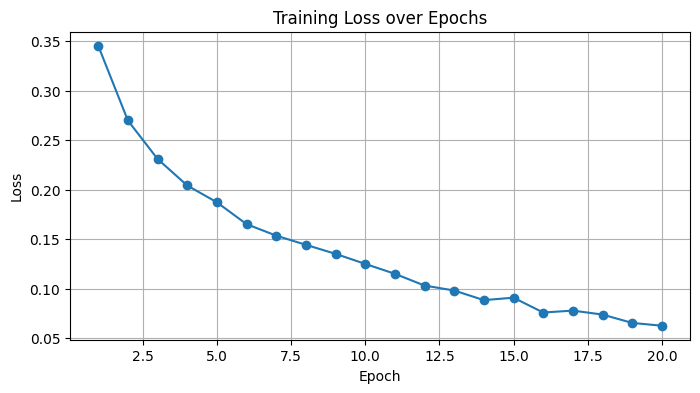

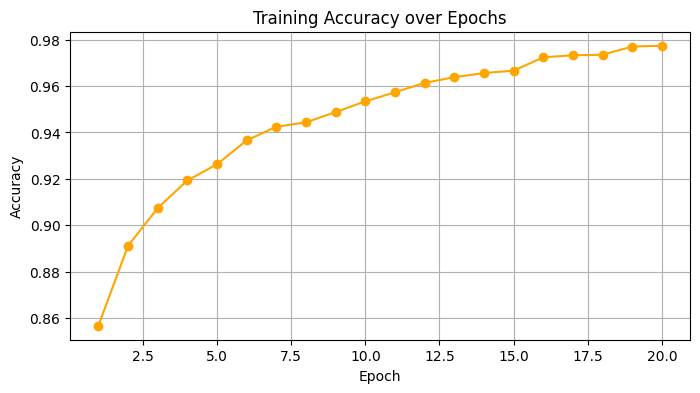

In [33]:
# evaluate the model (PyTorch style)
model.eval()
test_dataset = FireDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        preds = (outputs >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
avg_loss = test_loss / len(test_loader)
accuracy = correct / total

print(f"Final Test Accuracy: {accuracy * 100:.2f}%")
print(f"Final Test Loss: {avg_loss:.2f}")

# Plot training loss over epochs
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot training accuracy over epochs
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', color='orange')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

This block saves the model to a file named fire_classifier.pt in the same file path as this notebook.

In [34]:
# save the model for future use (PyTorch style)
torch.save(model.state_dict(), "fire_classifier.pt")

This block of code shows 6 random images from the test dataset and shows the models prediction next to the actual label to show examples of the model.

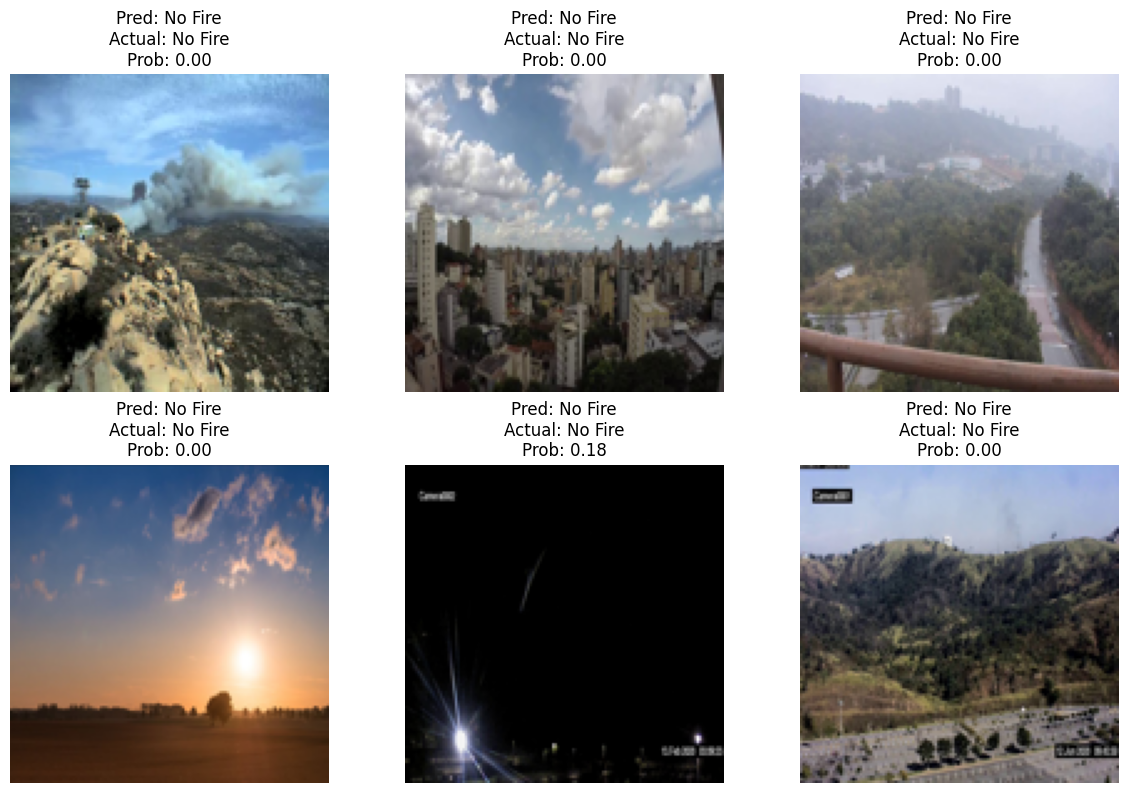

In [35]:
# show some example predictions from the test data using this model (PyTorch style)
num_examples = 6
indices = np.random.choice(len(X_test), num_examples, replace=False)

plt.figure(figsize=(12, 8))
model.eval()
for i, idx in enumerate(indices):
    img = X_test[idx]
    true_label = y_test[idx]
    # convert numpy image to PIL and then to tensor
    pil_img = Image.fromarray((img * 255).astype(np.uint8))
    input_tensor = transform(pil_img).unsqueeze(0)  # add batch dimension
    with torch.no_grad():
        pred_prob = model(input_tensor).item()
    pred_label = 1 if pred_prob >= 0.5 else 0
    plt.subplot(2, int(num_examples/2), i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {'Fire' if pred_label == 1 else 'No Fire'}\n"
              f"Actual: {'Fire' if true_label == 1 else 'No Fire'}\n"
              f"Prob: {pred_prob:.2f}")

plt.tight_layout()
plt.show()